In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras

data = pd.read_csv("/content/drive/MyDrive/ResearchProject/HAR/ppg+dalia/data/PPG_FieldStudy/S1/S1_E4/ACC_with_activity.csv")

X = data[["acc_x", "acc_y", "acc_z"]]
y = data["activity"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

# Normalize
X_train = StandardScaler().fit_transform(X_train)
X_val = StandardScaler().fit_transform(X_val)

#Used to find the k-value with highest accuracy
k = np.arange(1,100)
accuracy = np.array([])
percision = np.array([])
maxAccK = 0
maxPerk = 0
maxAcc = 0
maxPer = 0
for i in k:
    knn = KNeighborsClassifier(i)
    knn.fit(X_train, y_train)
    acc = (accuracy_score(y_val, knn.predict(X_val)))
    per = precision_score(y_val, knn.predict(X_val))
    accuracy = np.append(accuracy, acc)
    percision = np.append(percision, per)
    if acc > maxAcc:
        maxAccK = i
        maxAcc = acc
    if per > maxPer:
        maxPerK = i
        maxPer = per

plt.plot(k, accuracy)
plt.title("Model Accuracy Per K-Value")
plt.xlabel("K-Value")
plt.ylabel("Accuracy")
plt.show()

plt.plot(k, percision)
plt.title("Model Percision Per K-Value")
plt.xlabel("K-Value")
plt.ylabel("Percision")
plt.show()

#Using general KNN model
knn = KNeighborsClassifier(70)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
cmat = confusion_matrix(y_val, y_pred) #validate model predictions with actual y values
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmat, display_labels = [0, 1])
cm_display.plot()

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("Accuracy Rate: " + str(format(np.divide(np.sum([cmat[0,0],cmat[1,1]]),np.sum(cmat)))))


In [5]:
maxPerK

56

Epoch 1/200
468/468 [==============================] - 47s 83ms/step - loss: 0.4509 - binary_accuracy: 0.7745 - val_loss: 0.3999 - val_binary_accuracy: 0.7886
Epoch 2/200
468/468 [==============================] - 34s 73ms/step - loss: 0.3989 - binary_accuracy: 0.7979 - val_loss: 0.3818 - val_binary_accuracy: 0.8043
Epoch 3/200
468/468 [==============================] - 34s 74ms/step - loss: 0.3904 - binary_accuracy: 0.8022 - val_loss: 0.3754 - val_binary_accuracy: 0.8056
Epoch 4/200
468/468 [==============================] - 35s 75ms/step - loss: 0.3854 - binary_accuracy: 0.8043 - val_loss: 0.3745 - val_binary_accuracy: 0.8088
Epoch 5/200
468/468 [==============================] - 33s 70ms/step - loss: 0.3830 - binary_accuracy: 0.8047 - val_loss: 0.3695 - val_binary_accuracy: 0.8093
Epoch 6/200
468/468 [==============================] - 34s 73ms/step - loss: 0.3790 - binary_accuracy: 0.8074 - val_loss: 0.3698 - val_binary_accuracy: 0.8080
Epoch 7/200
468/468 [=========================

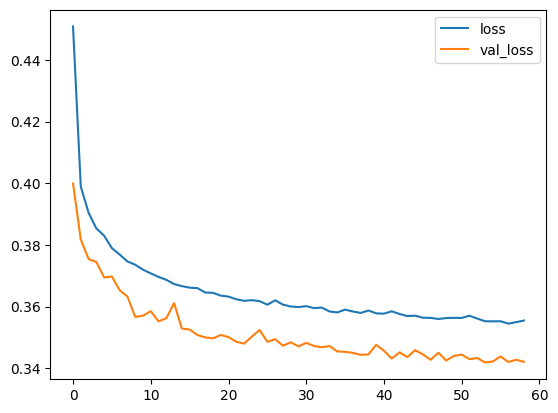

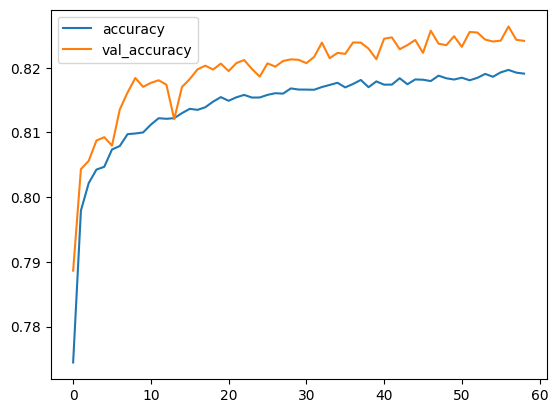

Accuracy Rate: 0.819091796875


In [ ]:
keras.utils.set_random_seed(0) #for reproducability
#Using general 3 layer neural network
model = keras.Sequential([
    keras.layers.BatchNormalization(input_shape=[X_train.shape[1]]),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics = ["binary_accuracy"]
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=512,
    epochs=200,
    callbacks=early_stopping,
)


history_df = pd.DataFrame(history.history)
plt.plot(range(history_df.shape[0]),history_df.loss, label="loss")
plt.plot(range(history_df.shape[0]),history_df.val_loss, label="val_loss")
plt.legend()
plt.show()
plt.plot(range(history_df.shape[0]),history_df.binary_accuracy,label="accuracy")
plt.plot(range(history_df.shape[0]),history_df.val_binary_accuracy,label="val_accuracy")
plt.legend()
plt.show()
print("Accuracy Rate: " + str(history_df.iat[history_df.shape[0]-1, 1]))

In [ ]:
def glucoseGrabber (data):
  start_index = data["Timestamp (YYYY-MM-DDThh:mm:ss)"].first_valid_index()
  relevent = data.iloc[start_index:]
  return relevent[["Timestamp (YYYY-MM-DDThh:mm:ss)", "Glucose Value (mg/dL)"]].rename(columns={"Timestamp (YYYY-MM-DDThh:mm:ss)": "datetime"})

# Resamples glucose data to 5 minute intervals according to the mean
# NO INTERPOLATING DONE
# Used for dexcom
def glucoseResampler(data):
  glucose = glucoseGrabber(data)
  glucose.loc[:, "datetime"] = pd.to_datetime(glucose["datetime"])
  glucose.set_index("datetime", inplace=True)
  ds_glucose = glucose.resample("5min").mean()
  ds_glucose.reset_index(inplace=True)
  return ds_glucose


In [ ]:
import os
import matplotlib.dates as mdates

patient = "001"
directory = f"/content/drive/MyDrive/ResearchProject/datafiles/{patient}"
food = pd.read_csv(f"/content/drive/MyDrive/ResearchProject/datafiles/{patient}/Food_Log_{patient}.csv", encoding='latin-1')

dexcom = pd.read_csv(f"/content/drive/MyDrive/ResearchProject/datafiles/{patient}/Dexcom_{patient}.csv", encoding='latin-1')
ds_glucose = glucoseResampler(dexcom)

food['time_begin'] = food.iloc[:,2]
food['time_begin'] = pd.to_datetime(food['time_begin'])


acc = pd.read_csv(os.path.join(directory, f"ACC_{patient}.csv"), encoding='latin-1')

acc["datetime"] = pd.to_datetime(acc["datetime"])
acc = acc.resample("5min", on="datetime").mean().reset_index()
acc = pd.merge(ds_glucose, acc, on='datetime')
acc.set_index('datetime', inplace=True)
acc = acc.dropna()
acc_no_glucose = acc.drop(columns=['Glucose Value (mg/dL)'])
acc_array = acc_no_glucose.to_numpy()

predictions = knn.predict(acc_array)
acc['predictions'] = predictions
acc = acc.reset_index()
acc["datetime"] = pd.to_datetime(acc["datetime"])

start_dates = []
end_dates = []

count = 0
start_index = 0

for i, row in acc.iterrows():
    if row['predictions'] == 1:
        if count == 0:
            start_index = i
        count += 1
    else:
        if count >= 3:
            start_dates.append(acc.iloc[start_index]['datetime'])
            end_dates.append(acc.iloc[i - 1]['datetime'])
        count = 0
        start_index = 0

# Check if the last sequence reached the end of the DataFrame
if count >= 3:
    start_dates.append(acc.iloc[start_index]['datetime'])
    end_dates.append(acc.iloc[i - 1]['datetime'])

# Create a new DataFrame with the start and end dates
periods = pd.DataFrame({'all_start': start_dates, 'all_end': end_dates})

# array to store periods of activity
above = []

# Find the start and end points of periods
starts = periods["all_start"]
ends = periods["all_end"]

# Last row ends period if it doesn"t end within the dataset
if len(starts) > len(ends) and len(ends) != 0:
    ends = pd.concat([ends, pd.Series(acc["datetime"].iloc[-1])])

for start_time, end_time in zip(starts, ends):
  food_start = start_time - pd.Timedelta(hours=1)
  food_end = end_time + pd.Timedelta(hours=1)
  if start_time <= pd.Timestamp(start_time.date()) + pd.Timedelta(hours=6):
    pass
  elif start_time >= pd.Timestamp(start_time.date()) + pd.Timedelta(hours=21):
    pass
  elif not (food[(food['time_begin'] >= food_start) & (food['time_begin'] <= food_end)]).empty:
    print("FOOOOOOOOOOOOOOOOOOOD")
  elif len(above) != 0 and start_time <= pd.Timestamp(above[-1][-1] + pd.Timedelta(hours=1)):
    pass
  else:
    above.append((start_time, end_time))

if len(above) != 0:
  above = np.array(above)
  start_times = above[:, 0]
  end_times = above[:, 1]
else:
  start_times = np.array([])
  end_times = np.array([])

start_times = pd.to_datetime(start_times)
end_times = pd.to_datetime(end_times)

activity = pd.DataFrame(columns = acc.columns)
for i, (start, end) in enumerate(zip(start_times, end_times)):
  # Filter DataFrame based on current period
  act = acc[acc['datetime'].between(start, (end + pd.Timedelta(hours=1)))]
  act["a"] = (end - start)
  act["a"] = act["a"].dt.total_seconds() / 60
  activity = pd.concat([activity, act])


FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD
FOOOOOOOOOOOOOOOOOOOD


<ipython-input-41-6b34cbe3cb9e>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act["a"] = (end - start)
<ipython-input-41-6b34cbe3cb9e>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  act["a"] = act["a"].dt.total_seconds() / 60
<ipython-input-41-6b34cbe3cb9e>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [ ]:
starts

0     2020-02-13 18:35:00
1     2020-02-13 19:05:00
2     2020-02-13 19:35:00
3     2020-02-13 22:35:00
4     2020-02-14 00:10:00
              ...        
97    2020-02-22 13:15:00
98    2020-02-22 14:05:00
99    2020-02-22 14:45:00
100   2020-02-22 15:20:00
101   2020-02-22 16:55:00
Name: all_start, Length: 102, dtype: datetime64[ns]

In [ ]:
path = os.path.join(directory, "KNNactivity_v1.csv")
activity.to_csv(path, index=False)